# Machine learning-based CHIR dose assessment and adjustment

In this notebook, we provide code for the machine learning-based CHIR dose assessment. We model the problem as a classification problem, where a classifier will learn to predict each well as "low", "optimal", or "high" under a given CHIR duration. We use the logistic regression classifier in our experiments. 

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score,roc_auc_score, auc,precision_recall_curve, roc_curve, f1_score
from matplotlib import pyplot as plt

In [2]:
df = pd.read_pickle("./data/dataset.pkl")
df_train = pd.read_pickle("./data/dataset_train.pkl")
df_test = pd.read_pickle("./data/dataset_test.pkl")

## Classification performance

We evaluate the performance of the logistic regression classifier by accuracy, precision, recall, F1-score, and AUC, under CHIR duration = 24h, 36h, and 48h (**Fig. 4e**).  

In [3]:
def machine_learning(clf, X_train, y_train, X_test, y_test):
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    auc = roc_auc_score(y_test, y_prob, average="macro", multi_class="ovr")
    
    return {
        "Accuracy" : acc, 
        "Precision" : precision, 
        "Recall": recall, 
        "F1 score": f1, 
        "AUC" : auc
    }

In [4]:
# CHIR duration = 24h
lr = LogisticRegression(penalty = "l1", solver = "liblinear", 
                        class_weight="balanced", C = 4, max_iter=1000
                       )
clf_24 = Pipeline([('scaler', StandardScaler()), ('classifier', lr)])
metrics_24 = machine_learning(clf_24,
                             X_train = df_train.feature.to_list(), y_train = df_train.label_24.to_numpy(),
                             X_test = df_test.feature.to_list(), y_test = df_test.label_24.to_numpy(),
                            )

# CHIR duration = 36h
lr = LogisticRegression(penalty = "l1", solver = "liblinear", 
                        class_weight="balanced", C = 8, max_iter=1000
                       )
clf_36 = Pipeline([('scaler', StandardScaler()), ('classifier', lr)])
metrics_36 = machine_learning(clf_36,
                             X_train = df_train.feature.to_list(), y_train = df_train.label_36.to_numpy(),
                             X_test = df_test.feature.to_list(), y_test = df_test.label_36.to_numpy(),
                            )

# CHIR duration = 48h
lr = LogisticRegression(penalty = "l1", solver = "liblinear", 
                        class_weight="balanced", C = 8, max_iter=1000
                       )
clf_48 = Pipeline([('scaler', StandardScaler()), ('classifier', lr)])
metrics_48 = machine_learning(clf_48,
                             X_train = df_train.feature.to_list(), y_train = df_train.label_48.to_numpy(),
                             X_test = df_test.feature.to_list(), y_test = df_test.label_48.to_numpy(),
                            )

# Put all the metrics in a table
df = pd.DataFrame([metrics_24, metrics_36, metrics_48], 
                  index = ["24h", "36h", "48h"], 
                 )

In [5]:
df.T

,24h,36h,48h
Accuracy,0.931034,0.844828,0.784483
Precision,0.886851,0.824045,0.758673
Recall,0.944697,0.815802,0.765378
F1 score,0.910936,0.819614,0.760143
AUC,0.971802,0.961135,0.945077


## Feature selection

We perform ANOVA-based feature selection to increase the generalization ability and robustness of the classification. The top four features with the most importance weights (i.e., $- \log_{10} {P\text{value}}$) are used to represent each well. Note that the feature importance weights should be derived on the training set. We again evaluate the classification performance using the same metrics (**Supplementary Fig. S10f**).

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif

# CHIR duration = 24h
lr = LogisticRegression(penalty = "l2", solver = "liblinear", 
                        class_weight="balanced", C = 10, max_iter=1000)
feature_selector_24 = SelectKBest(f_classif, k = 4)
clf_24_after_selection = Pipeline([('feature selection', feature_selector_24),
                ('scaler', StandardScaler()), 
                ('classifier', lr)])
metrics_24_after_selection = machine_learning(clf_24_after_selection,
                             X_train = df_train.feature.to_list(), y_train = df_train.label_24.to_numpy(),
                             X_test = df_test.feature.to_list(), y_test = df_test.label_24.to_numpy(),
                            )

# CHIR duration = 36h
lr = LogisticRegression(penalty = "l2", solver = "liblinear", 
                         class_weight="balanced", C = 10, max_iter=1000) 
feature_selector_36 = SelectKBest(f_classif, k = 4)
clf_36_after_selection = Pipeline([('feature selection', feature_selector_36),
                ('scaler', StandardScaler()), 
                ('classifier', lr)])
metrics_36_after_selection = machine_learning(clf_36_after_selection,
                             X_train = df_train.feature.to_list(), y_train = df_train.label_36.to_numpy(),
                             X_test = df_test.feature.to_list(), y_test = df_test.label_36.to_numpy(),
                            )

# CHIR duration = 48h
lr = LogisticRegression(penalty = "l2", solver = "liblinear",  
                         class_weight="balanced", C = 10, max_iter=1000) 
feature_selector_48 = SelectKBest(f_classif, k = 4)
clf_48_after_selection = Pipeline([('feature selection', feature_selector_48),
                ('scaler', StandardScaler()), 
                ('classifier', lr)])
metrics_48_after_selection = machine_learning(clf_48_after_selection,
                             X_train = df_train.feature.to_list(), y_train = df_train.label_48.to_numpy(),
                             X_test = df_test.feature.to_list(), y_test = df_test.label_48.to_numpy(),
                            )

# Put all the metrics in a table
df_after_selection = pd.DataFrame([metrics_24_after_selection,
                                   metrics_36_after_selection,
                                   metrics_48_after_selection
                                  ], 
                                  index = ["24h", "36h", "48h"], 
                                 )

In [7]:
df_after_selection.T

,24h,36h,48h
Accuracy,0.810345,0.637931,0.663793
Precision,0.730057,0.578768,0.623623
Recall,0.752868,0.628402,0.683931
F1 score,0.737568,0.593514,0.639017
AUC,0.904221,0.828751,0.788847


We can also visualize the feature importance. Here we show the feature importance for CHIR duration = 24h (**Supplementary Fig. S10b**). 

In [8]:
with open("./data/feature_name.txt") as f:
    feature_name_list = f.readlines()
feature_name_list = list(filter(lambda st: st != "", feature_name_list))
for i in range(len(feature_name_list)):
    feature_name_list[i] = feature_name_list[i].strip("\n")

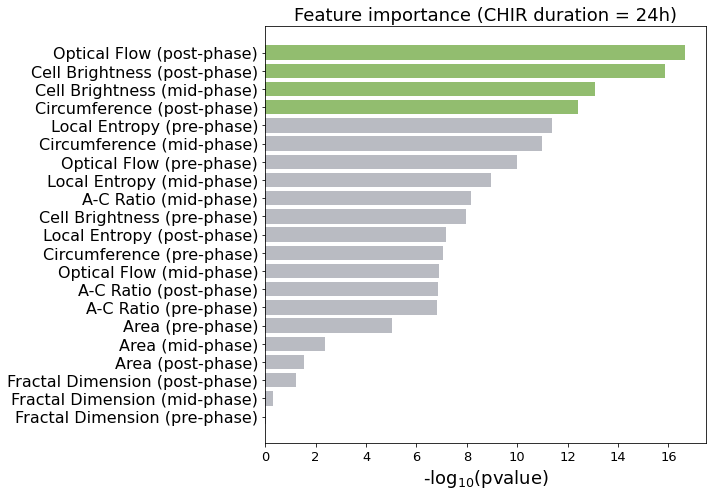

In [9]:
selected_idx, pvalues = feature_selector_24.get_support().nonzero(), feature_selector_24.pvalues_

sorted_idx = np.argsort(pvalues)[::-1]
importance = -np.log10(pvalues)
sorted_importance = importance[sorted_idx]
sorted_label = np.array([feature_name_list[i] for i in sorted_idx])

# plot the bar chart.
plt.figure(figsize=(10, 7))
plt.barh(range(21), sorted_importance, color = [(185/255, 187/255, 194/255)]*17 + [(146/255, 189/255, 111/255)]*4)
plt.yticks(range(21), sorted_label, fontsize=16)
plt.xticks(fontsize = 13)
plt.xlabel("-log$_{10}$(pvalue)", fontsize=18)
plt.title("Feature importance (CHIR duration = 24h)", fontsize=18)
plt.tight_layout()
plt.show()

## Deviation Scores

The trained classifer can also provide guidance for CHIR dose adjust,ment. Concretely, the classifier can predict a "Deviation Score" for each CHIR concentration $c$ under a given CHIR concentration. Let $N_c$ be the number of wells with concentration $c$, among which $N_c^\text{low}, N_c^\text{optimal}, N_c^\text{high}$ wells are predicted as low, optimal, and high, respectively. The Deviation Score is defined by $(N_c^\text{high} - N_c^\text{low}) / N_c$, ranging from -1 to 1, which could reflect the deviation of the CHIR concentration from the optimal conditions. 

We computed the Deviation Scores for each CHIR dose applied in batch CD01-1 (**Fig. 4f**). One can see that the predicted Deviation Scores matched with the true "ΔCHIR concentration". 

In [10]:
deviation_scores = [] # the predicted deviation scores
delta_concs = [] # the true ΔCHIR concentration

clfs = {24:clf_24, 36:clf_36, 48:clf_48}
test_batch = df_test[df_test.batch_name == "CD01-1"]
CHIR_concs = np.sort(test_batch.CHIR_conc.unique())

for duration in (24, 36, 48):
    
    clf = clfs[duration]
    score = {}
    delta_conc = {}
    for concentration in CHIR_concs:
        pred_label = clf.predict(test_batch[test_batch.CHIR_conc == concentration].feature.to_list())
        score["%d μM" % concentration] = (pred_label == "high").mean() - (pred_label == "low").mean()
        delta_conc["%d μM" % concentration] = test_batch.loc[test_batch.CHIR_conc == concentration, 
                                                         "delta_CHIR_conc_%d" % duration
                                                        ].iloc[0]
    
    deviation_scores.append(score)
    delta_concs.append(delta_conc)


df_deviation_score = pd.DataFrame(deviation_scores, index = ["24h", "36h", "48h"])
df_delta_concs = pd.DataFrame(delta_concs, index = ["24h", "36h", "48h"])

In [11]:
# The predicted Deviation Scores
df_deviation_score

,4 μM,6 μM,8 μM,10 μM
24h,-1.0,-0.111111,0.4,1.000000
36h,0.0,0.111111,0.6,1.000000
48h,0.0,0.000000,0.6,0.857143


In [12]:
# The true ΔCHIR concentration
df_delta_concs

,4 μM,6 μM,8 μM,10 μM
24h,-2,0,0,2
36h,0,0,2,4
48h,0,0,2,4


In [13]:
# Compute the Pearson's r

from scipy import stats

r, p = stats.pearsonr(df_deviation_score.to_numpy().ravel(), 
                       df_delta_concs.to_numpy().ravel())

print("Pearson's r = ", r)
print("p = ", p)

Pearson's r =  0.9055949090259772
p =  5.030836219216342e-05


The predicted Deviation Scores can help select the CHIR duration. Next we show that using the optimal CHIR duration selected by ML, the differentiation efficiency can be improved and batch-to-batch variation can be reduced (**Fig. 4h**). 

Suppose the preset condition is CHIR concentration = 8μM, CHIR duration = 48h. At an early stage (~12h), we run the trained ML models on different batches and obtain their Deviation Scores at different CHIR durations (24h, 36h, and 48h).

In [14]:
deviation_scores = [] # the predicted deviation scores
batch_names = ["CD01-1", "CD01-2", "CD01-3", "CD01-4"]

clfs = {24:clf_24, 36:clf_36, 48:clf_48}

concentration = 8 # preset concentration

for batch_name in batch_names:

    test_batch = df_test[df_test.batch_name == batch_name]
    score = {}

    for duration in (24, 36, 48):

        clf = clfs[duration]
        pred_label = clf.predict(test_batch[test_batch.CHIR_conc == concentration].feature.to_list())
        score["%d h" % duration] = (pred_label == "high").mean() - (pred_label == "low").mean()

    deviation_scores.append(score)

df_deviation_score = pd.DataFrame(deviation_scores, index = batch_names)

In [15]:
df_deviation_score

,24 h,36 h,48 h
CD01-1,0.4,0.60,0.6
CD01-2,0.0,0.25,1.0
CD01-3,0.0,0.00,0.0
CD01-4,0.0,0.00,0.0


In [16]:
optimal_duration = {}
for batch in batch_names:
    for duration in (24, 36, 48):
        if df_deviation_score.loc[batch, "%d h" % duration] >= 0:
            optimal_duration[batch] = duration
        break
print("ML-selected duration: ", optimal_duration)

ML-selected duration:  {'CD01-1': 24, 'CD01-2': 24, 'CD01-3': 24, 'CD01-4': 24}


One can find that ML sugguested that using CHIR duration = 24h, 24h, 24h, 24h (for batch CD01-1, CD01-2, CD01-3, CD01-4, respectively) will be better. Then we compare the differentiation efficiency under the preset condition (8μM, 48h) with optimized condition (8μM, ML-selected duration).

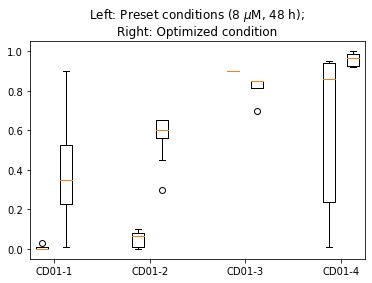

In [17]:
exp_result = [pd.read_csv("./data/%s/%s_exp_config.csv" % (batch_name, batch_name), index_col = 0)
               for batch_name in batch_names]

concentration = 8
duration = 48

before = [df.loc[(df.chir == concentration) & (df.chir_hour == duration), "percentage_of_cTNT+_cells"] 
          for batch_name, df in zip(batch_names, exp_result)]
after = [df.loc[(df.chir == concentration) & (df.chir_hour == optimal_duration[batch_name]), 
                "percentage_of_cTNT+_cells"] 
          for batch_name, df in zip(batch_names, exp_result)]


plt.boxplot(
    positions = [1, 5, 9, 13],
    x=before,
)
plt.boxplot(
    positions = [2, 6, 10, 14],
    x=after,
)
plt.xticks([1.5, 5.5, 9.5, 13.5], labels = batch_names)
plt.title("Left: Preset conditions (%d $\mu$M, %d h); \nRight: Optimized condition" % (concentration, duration))
plt.show()